In [62]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalg
import os
import time
from ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from utils.plotting import draw_ellipse, images_to_gif
from utils.filesTools import get_exp_folder
from utils.notionConnector import add_experiment_to_notion
from pathlib import Path

In [56]:
import importlib
import utils.notionConnector
importlib.reload(utils.notionConnector)
from utils.notionConnector import add_experiment_to_notion

In [ ]:
## setup params
NUM_OF_BEACONS = 4
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.3
sigma_measurement = 0.1
stepsize = 2
n_steps = 50
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_agent = [0 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon = [0 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon[0:6] = [sigma_transition_beacon**2]*6
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)


In [61]:
# state manger
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x
## model definition
'''
Function to propagate the state based on the control input and a normal model
'''
propagate_state_function = lambda x, u: x + sample_normal_model(u, cov_transition)


def calculate_true_range_meas(x):
    """
    Function to calculate the true range measurements.
    It calculates the Euclidean distance between each agent and each beacon.
    """
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    '''
    Function to generate the range measurements model.
    It adds a normally distributed noise to the true range measurements.
    '''
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

'''
function to calculates the likelihood of the measurements given the state.
It uses a normal probability density function with the true range measurements
as the mean and the measurement covariance as the covariance
'''
measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)
## test models and conversion functions
if 0:
    x_i = np.array([0, 0, 1, 0, 2, 0, 3, 0, 4, 0])*100
    u = np.zeros(TOTAL_STATE_SIZE)
    print(measurements_model(x_i))
    print(propagate_state_function(x_i, u))
## test conversion functions
if 0:
    x_i = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
    agents_pos, beacons_pos = state_to_agent_and_beacons_pos(x_i)
    print(agents_pos, beacons_pos)
    print(agent_and_beacons_pos_to_state(agents_pos, beacons_pos))
# pf Utils functions
def draw_frame(x,particles,frames_folder,i,ellipse = True):
    colors = ['r', 'g', 'b', 'y', 'm']
    fig, ax = plt.subplots()
    for j in range(NUM_OF_AGENTS):
        agent_gt_pos = x[get_agent_index(j),i]
        agent_particles = particles[:,get_agent_index(j)]
        agent_color = colors[j]
        ax.scatter(agent_gt_pos[0], agent_gt_pos[1], color = agent_color)
        if ellipse:
            draw_ellipse(ax, edgecolor = agent_color ,data = agent_particles)
        else:
            ax.scatter(agent_particles[:,0], agent_particles[:,1], c = agent_color, marker = 'x')
            
    for j in range(NUM_OF_BEACONS):
        beacon_gt_pos = x[get_beacon_index(j),i]
        beacon_particles = particles[:,get_beacon_index(j)]
        beacon_color = colors[j+NUM_OF_AGENTS]
        ax.scatter(beacon_gt_pos[0], beacon_gt_pos[1], color = beacon_color)
        if ellipse:
            draw_ellipse(ax, edgecolor= beacon_color ,data = beacon_particles)
        else:
            ax.scatter(beacon_particles[:,0], beacon_particles[:,1], c = beacon_color, marker = 'x')
    
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    plt.title(f'frame {i}')
    plt.savefig(f'{frames_folder}/frame_{i}.png')
    plt.close()
    
def calculate_mean_and_cov(particles):
    mean = np.mean(particles, axis = 0)
    cov = np.cov(particles.T).flatten()
    return mean, cov

def save_ground_truth(x, z, exp_folder):
    pd.DataFrame(x).to_csv(f'{exp_folder}/ground_truth_state.csv')
    pd.DataFrame(z).to_csv(f'{exp_folder}/ground_truth_measurement.csv')

def save_current_particles(particles, exp_folder, i):
    if not os.path.exists(exp_folder):
        os.makedirs(exp_folder)
    if not os.path.exists(f'{exp_folder}/particles'):
        os.makedirs(f'{exp_folder}/particles')
    pd.DataFrame(particles).to_csv(f'{exp_folder}/particles/particles_{i}.csv')

def run_particle_filter_experiment(note, particles, n_steps, total_state_size, x, u, z, propagate_state_function, measurements_likelihood_function, resample_method='systematic', save_particles=False, ellipse=True):
    exp_folder, frames_folder = get_exp_folder(note = note)
    mean_log = np.zeros((n_steps, total_state_size))
    cov_log = np.zeros((n_steps, total_state_size**2))

    for i in range(n_steps):
        if 1:
            draw_frame(x, particles, frames_folder, i, ellipse = ellipse)
        if save_particles:
            save_current_particles(particles, exp_folder, i)
        
        particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state_function, measurements_likelihood_function, resample_method = resample_method)
        mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
        print(f"\r{i}/{n_steps}", end='', flush=True)
    print('\n')
    if 1:
        draw_frame(x, particles, frames_folder, i = n_steps - 1, ellipse = ellipse)
    if save_particles:
        save_current_particles(particles, exp_folder, i)
    images_to_gif(frames_folder, f'{exp_folder}/particle_filter.gif')
    pd.DataFrame(mean_log).to_csv(f'{exp_folder}/mean_log.csv', index = False, header = False)
    pd.DataFrame(cov_log).to_csv(f'{exp_folder}/cov_log.csv', index = False, header = False)
    save_ground_truth(x, z, exp_folder)
    try:
        path_ = Path(exp_folder)
        folder_name = path_.name
        exp_data = {"Name": folder_name, "folder path": exp_folder}
        add_experiment_to_notion(exp_data)
    except:
        print('Failed to add experiment to notion')

    return mean_log, cov_log, exp_folder, particles

In [ ]:
## generate ground truth
agent_position_0 = np.array([0,0])
becons_1_position_0 = np.array([10,10])
becons_2_position_0 = np.array([-10,10])
becons_3_position_0 = np.array([10,-10])
becons_4_position_0 = np.array([-10,-10])
x_0 = agent_and_beacons_pos_to_state([agent_position_0], [becons_1_position_0, becons_2_position_0, becons_3_position_0, becons_4_position_0])

#genrate u  commend vector
u = (np.random.rand(TOTAL_STATE_SIZE, n_steps) - 0.5) * stepsize
u = np.zeros((TOTAL_STATE_SIZE, n_steps))
u[get_agent_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize
u[get_beacon_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(1),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(2),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(3),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
## create ground truth
x = np.zeros((TOTAL_STATE_SIZE, n_steps))
x[:,0] = x_0
z = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z[:,0] = measurements_model(x[:,0])
for i in range(1, n_steps):
    x[:,i] = propagate_state_function(x[:,i-1], u[:,i-1])
    z[:,i] = measurements_model(x[:,i])

## plot ground truth
if 0:
    fig, ax = plt.subplots()
    ax.plot(x[0,:], x[1,:], 'r')
    ax.plot(x[2,:], x[3,:], 'g')
    ax.plot(x[4,:], x[5,:], 'b')
    ax.plot(x[6,:], x[7,:], 'y')
    ax.plot(x[8,:], x[9,:], 'm')
    plt.show()


In [63]:
NOTE = 'gradient_data'
SAVE_EACH_FRAME = 1
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
particles[:,get_agent_index(0)] = np.zeros((n_particles, STATE_SIZE_2D))
particles[:,get_beacon_index(0)] = particles[:,get_beacon_index(0)] + becons_1_position_0
particles[:,get_beacon_index(1)] = particles[:,get_beacon_index(1)] + becons_2_position_0
particles[:,get_beacon_index(2)] = particles[:,get_beacon_index(2)] + becons_3_position_0
particles[:,get_beacon_index(3)] = particles[:,get_beacon_index(3)] + becons_4_position_0


pf_outputs = run_particle_filter_experiment(note = NOTE,
                                                    n_steps= n_steps,
                                                    particles = particles,
                                                    total_state_size = TOTAL_STATE_SIZE,
                                                    x = x,
                                                    u = u,
                                                    z = z,
                                                    propagate_state_function=propagate_state_function,
                                                    measurements_likelihood_function = measurements_likelihood,
                                                    resample_method='systematic',
                                                    save_particles=SAVE_EACH_FRAME,
                                                    ellipse=False)

49/50

gif saved to results\20240517\exp_20240517_175817_gradient_data/particle_filter.gif
Experiment added successfully!


In [ ]:
#load particles for frame number 3
data_folfder = pf_outputs[2]
particles = pd.read_csv(f'{data_folfder}/particles/particles_3.csv',index_col=0)
particles.columns = ['ax', 'ay', 'bx1', 'by1', 'bx2', 'by2', 'bx3', 'by3', 'bx4', 'by4']
particles_mean = particles.mean(axis = 0)
particles_mean

In [ ]:
dzest_dx = np.zeros((RANGE_MEASUREMENT_SIZE, TOTAL_STATE_SIZE))
for i in range(NUM_OF_AGENTS):
    agent_pos = particles_mean[get_agent_index(i)].values
    for j in range(NUM_OF_BEACONS):
        beacon_pos = particles_mean[get_beacon_index(j)].values
        z_est = np.linalg.norm(agent_pos - beacon_pos)
        dx = agent_pos - beacon_pos
        dzest_dx[i*NUM_OF_BEACONS + j, get_agent_index(i)] =   dx/z_est
        dzest_dx[i*NUM_OF_BEACONS + j, get_beacon_index(j)] = -dx/z_est
print(f"{dzest_dx=}")
dLdz = np.zeros((1, RANGE_MEASUREMENT_SIZE))
inv_cov = np.linalg.inv(cov_measurement)
dz = z[:,3] - calculate_true_range_meas(particles_mean.values)
dLdz = -2 * dz @ inv_cov
print(f"{dLdz=}")
L_of_x = measurements_likelihood(z[:,3], particles_mean.values)
print(f"{L_of_x=}")
dLdx = -0.5 * L_of_x * dLdz @ dzest_dx
print(f"{dLdx=}")
# normalize the gradient in pairs of 2
for i in range(NUM_OF_AGENTS):
    norm = np.linalg.norm(dLdx[2*i:2*(i+1)])
    dLdx[2*i:2*(i+1)] = dLdx[2*i:2*(i+1)]/norm
for j in range(NUM_OF_BEACONS):
    norm = np.linalg.norm(dLdx[2*NUM_OF_AGENTS + 2*j:2*NUM_OF_AGENTS + 2*(j+1)])
    dLdx[2*NUM_OF_AGENTS + 2*j:2*NUM_OF_AGENTS + 2*(j+1)] = dLdx[2*NUM_OF_AGENTS + 2*j:2*NUM_OF_AGENTS + 2*(j+1)]/norm
print (f"{dLdx=}")
#print the mean of the particles and an arrow that shows the gradient
fig, ax = plt.subplots()
ax.scatter(particles_mean.iloc[0], particles_mean.iloc[1], color = 'r')
# ax.arrow(particles_mean.iloc[0], particles_mean.iloc[1], dLdx[0], dLdx[1])
ax.arrow(particles_mean.iloc[0], particles_mean.iloc[1], dLdx[1], -dLdx[0], width  = 0.2, color = 'r')

ax.scatter(particles_mean.iloc[2], particles_mean.iloc[3], color = 'g')
# ax.arrow(particles_mean.iloc[2], particles_mean.iloc[3], dLdx[2], dLdx[3])
ax.arrow(particles_mean.iloc[2], particles_mean.iloc[3], dLdx[3], -dLdx[2], width  = 0.2, color = 'g')

ax.scatter(particles_mean.iloc[4], particles_mean.iloc[5], color = 'b')
# ax.arrow(particles_mean.iloc[4], particles_mean.iloc[5], dLdx[4], dLdx[5])
ax.arrow(particles_mean.iloc[4], particles_mean.iloc[5], dLdx[5], -dLdx[4], width  = 0.2, color = 'b')

ax.scatter(particles_mean.iloc[6], particles_mean.iloc[7], color = 'y')
# ax.arrow(particles_mean.iloc[6], particles_mean.iloc[7], dLdx[6], dLdx[7])
ax.arrow(particles_mean.iloc[6], particles_mean.iloc[7], dLdx[7], -dLdx[6], width  = 0.2, color = 'y')

ax.scatter(particles_mean.iloc[8], particles_mean.iloc[9], color = 'm')
# ax.arrow(particles_mean.iloc[8], particles_mean.iloc[9], dLdx[8], dLdx[9])
ax.arrow(particles_mean.iloc[8], particles_mean.iloc[9], dLdx[9], -dLdx[8], width  = 0.2, color = 'm')

## add the ground truth
ax.scatter(x[0,3], x[1,3], color = 'r', marker='x')
ax.scatter(x[2,3], x[3,3], color = 'g', marker='x')
ax.scatter(x[4,3], x[5,3], color = 'b', marker='x')
ax.scatter(x[6,3], x[7,3], color = 'y', marker='x')
ax.scatter(x[8,3], x[9,3], color = 'm', marker='x')
plt.show()

In [49]:
def calculate_gradient(x_i, z_i, normalize = True):
    #check if x is a pandas series
    # the gradient is calculated with respect to the state vector x,
    # the furmula is dL/dx = -0.5 * L(x) * dL/dz * dz/dx
    # Where L(x) is the likelihood of the measurements given the state x
    # dL/dz is the gradient of the likelihood with respect to the measurements
    # dz/dx is the gradient of the measurements with respect to the state
    if type(x_i) == pd.Series:
        x_i = x_i.values
    dzest_dx = np.zeros((RANGE_MEASUREMENT_SIZE, TOTAL_STATE_SIZE))
    for i in range(NUM_OF_AGENTS):
        agent_pos = x_i[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            beacon_pos = x_i[get_beacon_index(j)]
            z_est = np.linalg.norm(agent_pos - beacon_pos)
            dx = agent_pos - beacon_pos
            dzest_dx[i*NUM_OF_BEACONS + j, get_agent_index(i)] =   dx/z_est
            dzest_dx[i*NUM_OF_BEACONS + j, get_beacon_index(j)] = -dx/z_est

    dLdz = np.zeros((1, RANGE_MEASUREMENT_SIZE))
    inv_cov = np.linalg.inv(cov_measurement)
    dz = z_i - calculate_true_range_meas(x_i)
    dLdz = -2 * dz @ inv_cov

    L_of_x = measurements_likelihood(z_i, x_i)
    normlized_dLdX = dLdz @ dzest_dx # this will be normalized later, just initilize it here without common factors
    dLdx = -0.5 * L_of_x * normlized_dLdX
    dLdx = normlized_dLdX.copy()

    
    # normalize the gradient in pairs of 2
    if normalize: 
        # normlized_dLdX = np.zeros(TOTAL_STATE_SIZE) # we dont not need to create a new array, we can use the same one
        for i in range(NUM_OF_AGENTS):
            norm = np.linalg.norm(dLdx[2*i:2*(i+1)])
            normlized_dLdX[2*i:2*(i+1)] = dLdx[2*i:2*(i+1)]/norm
        for j in range(NUM_OF_BEACONS):
            norm = np.linalg.norm(dLdx[2*NUM_OF_AGENTS + 2*j:2*NUM_OF_AGENTS + 2*(j+1)])
            normlized_dLdX[2*NUM_OF_AGENTS + 2*j:2*NUM_OF_AGENTS + 2*(j+1)] = dLdx[2*NUM_OF_AGENTS + 2*j:2*NUM_OF_AGENTS + 2*(j+1)]/norm

    return dLdx, normlized_dLdX

## test the gradient calculation
calculate_gradient(particles_mean, z[:,3], normalize = True)

(array([ 100.75722408,    5.62633274,  -20.83342451,  -22.13803994,
         103.10373617,  -33.92999288, -138.08528721,   81.04490491,
         -44.94224851,  -30.60320483]),
 array([ 0.99844456,  0.05575363, -0.68532322, -0.72823903,  0.9498867 ,
        -0.31259439, -0.86242984,  0.50617662, -0.82656308, -0.5628441 ]))

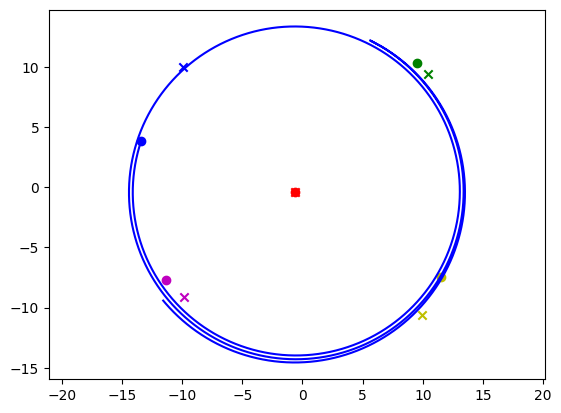

In [50]:
iso_liklihood = np.zeros((2,2000))
un_normlized_gradient_log = np.zeros((STATE_SIZE_2D, 2000))
current_beacon_2_pos = particles_mean[get_beacon_index(1)].values.copy()
x_current = particles_mean.values.copy()
for i in range(2000):
    (un_normlized_gradient,gradient) = calculate_gradient(x_current, z[:,3], normalize = True)
    un_normlized_gradient_log[:,i] = un_normlized_gradient[4:6]
    beacon_1_gradient = gradient[4:6]
    direction = np.array([beacon_1_gradient[1], -beacon_1_gradient[0]])
    iso_liklihood[:,i] = x_current[get_beacon_index(1)]
    x_current[get_beacon_index(1)] = x_current[get_beacon_index(1)] + 0.1 * direction
    
fig, ax = plt.subplots()
ax.scatter(particles_mean.iloc[0], particles_mean.iloc[1], color = 'r')

ax.scatter(particles_mean.iloc[2], particles_mean.iloc[3], color = 'g')

ax.scatter(particles_mean.iloc[4], particles_mean.iloc[5], color = 'b')

ax.scatter(particles_mean.iloc[6], particles_mean.iloc[7], color = 'y')

ax.scatter(particles_mean.iloc[8], particles_mean.iloc[9], color = 'm')

## add the ground truth
ax.scatter(x[0,3], x[1,3], color = 'r', marker='x')
ax.scatter(x[2,3], x[3,3], color = 'g', marker='x')
ax.scatter(x[4,3], x[5,3], color = 'b', marker='x')
ax.scatter(x[6,3], x[7,3], color = 'y', marker='x')
ax.scatter(x[8,3], x[9,3], color = 'm', marker='x')
ax.plot(iso_liklihood[0,:], iso_liklihood[1,:], color = 'b')
# set axis to equal
plt.axis('equal')
plt.show()


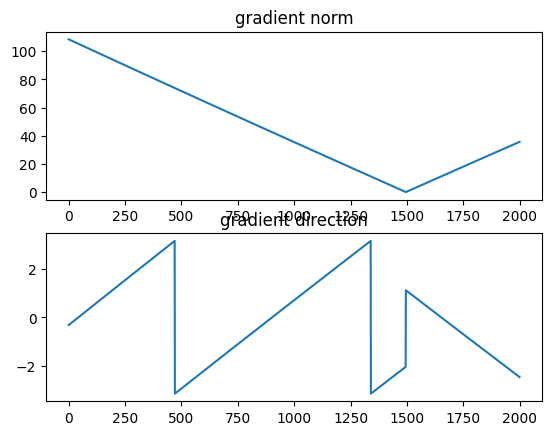

In [51]:
un_normlized_gradient_norm= np.linalg.norm(un_normlized_gradient_log, axis = 0)
un_normlized_gradient_norm.shape
gradient_direction_angle = np.arctan2(un_normlized_gradient_log[1,:], un_normlized_gradient_log[0,:])
#plot norm and direction with subplots
fig, ax = plt.subplots(2)
ax[0].plot(un_normlized_gradient_norm)
ax[0].set_title('gradient norm')
ax[1].plot(gradient_direction_angle)
ax[1].set_title('gradient direction')
plt.show()